# Motor Controller SNN with e-prop (NEST)

This notebook demonstrates how to use the motor controller spiking neural network (SNN) model implemented in NEST Simulator ([repository link](https://github.com/shimoura/motor-controller-model/tree/add-nestml-neurons/eprop-motor-control)). The network models motor cortex (M1) activity for a movement task, using e-prop learning as implemented in NEST.

Here is presented how to:
- Set up and run the simulation for a motor controller network using joint angle trajectories (robot arm as a reference)
- Analyze spike trains, output signals, and the loss curve

> **Note:** This notebook is intended to demonstrate usage of this specific code/model. For background on e-prop or SNNs, see the references and [NEST e-prop examples](https://nest-simulator.readthedocs.io/en/stable/auto_examples/eprop_plasticity/index.html).

<p align="center">
  <img src="overview_network.png" alt="Motor controller SNN schematic" width="800"/>
</p>

**Figure 1. Schematic of the spiking neural network (SNN) architecture for motor control.**  
On the left, labeled "input neurons," time-varying joint angles are received as external signals. These signals are projected into a central recurrent network (reservoir), which models the motor cortex (M1). Within the reservoir, black triangles represent individual excitatory spiking neurons, while the red circle at the bottom denotes the inhibitory neuron population—crucial for dynamically balancing network activity via recurrent inhibition.  
The recurrent network outputs to two readout neurons via e-prop synapses: a red circle ("pos" channel) and a blue circle ("neg" channel), each corresponding to a motor output direction. Gray arrows from these readout neurons point to target signals, illustrating supervised learning via error comparison. The purple arrow labeled "B" represents the feedback path by which the readout neurons send the e-prop learning signal (global error signal) back to the recurrent network, enabling biologically plausible online synaptic adaptation.  
Colors and shapes explicitly encode network roles: labeled input neurons (left), excitatory reservoir neurons (black triangles), inhibitory population (red circle), and output channels (red and blue circles).

## Neuroscience and Technical Context

- **Motor Controller Network:**
  This spiking neural network (SNN) models essential computational principles of the mammalian primary motor cortex (M1) in the context of sensorimotor control. It receives time-varying joint angles—such as those generated by a robotic arm or biological limb—as input, and translates these into output signals that drive movement execution. The architecture leverages population coding and recurrent connectivity to capture dynamics and adaptive control strategies observed in biological motor systems.

- **Radial Basis Function (RBF) Encoding:**
  RBF encoding transforms continuous joint angles into population activity over a set of neural units, each with a preferred value (center). The response of each unit is governed by a radial (typically Gaussian) function—peaking at its center and tapering smoothly away. This produces a distributed, overlapping population representation, closely mimicking biological sensory and motor representations seen in cortex.

  In this repository, RBF encoding produces a population vector of real-valued activities for each input. These activities are then converted to spike trains, either by thresholding or by driving input neuron models (including NESTML-based neurons). Thus, RBF encoding itself does not directly generate spikes, but provides a biologically plausible population representation that facilitates robust learning and generalization in SNNs.

  *References:*
  - Pouget A, Dayan P, Zemel RS (2000), Nature Reviews Neuroscience: [Information processing with population codes](https://www.nature.com/articles/35039062)
  - Georgopoulos AP, Schwartz AB, Kettner RE (1986), Science: [Neuronal population coding of movement direction](https://www.science.org/doi/10.1126/science.3749885)

- **e-prop Learning (NEST Implementation):**
  Synaptic plasticity in our model uses NEST’s native e-prop synapse. E-prop combines local eligibility traces and a global learning signal (e.g., error or reward), analogous to neuromodulatory feedback in the brain. This enables efficient, online, and biologically plausible synaptic updates during simulation. For more details see [NEST e-prop documentation](https://nest-simulator.readthedocs.io/en/stable/auto_examples/eprop_plasticity/index.html), Bellec et al., Nature Comm. 2020 ([doi](https://doi.org/10.1038/s41467-020-17236-y)).

## 1. Imports

Standard scientific Python libraries, and your main simulation routine. The code is designed to be run from the repository directory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add your motor-control code directory to Python path
sys.path.append(str((Path.cwd() / "eprop-motor-control").resolve()))

# Import simulation routine
from eprop_reaching_task import run_simulation


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## 2. Simulation Parameters

Define the dataset files and model hyperparameters. Joint angle data for the robot arm is used as input (see the `dataset_motor_training/stage1` directory).

- **RBF encoding parameters** (`num_centers`, `rbf_width`) control how finely the continuous joint angles are population-coded.
- **Learning rates** determine how quickly synapses update with e-prop.
- **Number of neurons** (`n_rec`, `n_out`) sets network size.
- **Training iterations** (`n_iter`) sets number of iteration.
- **Weights** (`w_input`, `w_rec`) set initial connectivity weigth between input to recurrent network, and between excitatory recurrent connections, respectively. Inhibitory connections are initialized as four times bigger than excitatory connections.

> *Note: The model can use NESTML for encoding, but the default here is standard Python RBF encoding. See repository documentation for details.*

In [2]:
base_data_dir = Path('dataset_motor_training') / 'stage1'

trajectory_files = [
    str(base_data_dir / 'trajectories_90_to_140.txt'),
    str(base_data_dir / 'trajectories_90_to_20.txt'),
]
target_files = [
    str(base_data_dir / 'spikes_from_90_to_140.txt'),
    str(base_data_dir / 'spikes_from_90_to_20.txt'),
]

params = dict(
    trajectory_files=trajectory_files,
    target_files=target_files,
    n_rec=300,                		 # Number of recurrent neurons (M1 population)
    n_out=2,                  		 # Output channels: pos and neg
    learning_rate_exc=0.03,   		 # Excitatory synapse learning rate
    learning_rate_inh=0.03,   	     # Inhibitory synapse learning rate
    use_manual_rbf=True,     		 # Use Python RBF encoding (set False for NESTML)
    result_dir='./tutorial_results', # Output directory for results
    plot_results=False,       		 # We'll plot interactively below
)

additional_params = {
    "task.n_iter": 50,  		# Number of training iterations
    "rbf.num_centers": 20,  		# Number of RBF centers
    "rbf.width": 0.1,    		# RBF width
	"synapses.w_input": 100,    # Initial input synaptic weight
	"synapses.w_rec": 40,       # Initial recurrent synaptic weight)
}

params.update(additional_params)

## 2.1 Visualizing Loaded Trajectories and Target Spike Patterns

Before running the simulation, inspect the loaded joint angle trajectories and their corresponding target spike rasters.  

Below, each column shows the joint angle trajectory (top) and the corresponding target spike rate signals for "pos" (blue) and "neg" (red) channels (bottom).  
This visualization matches the output signal analysis later in the notebook and helps confirm correct input/target pairing.

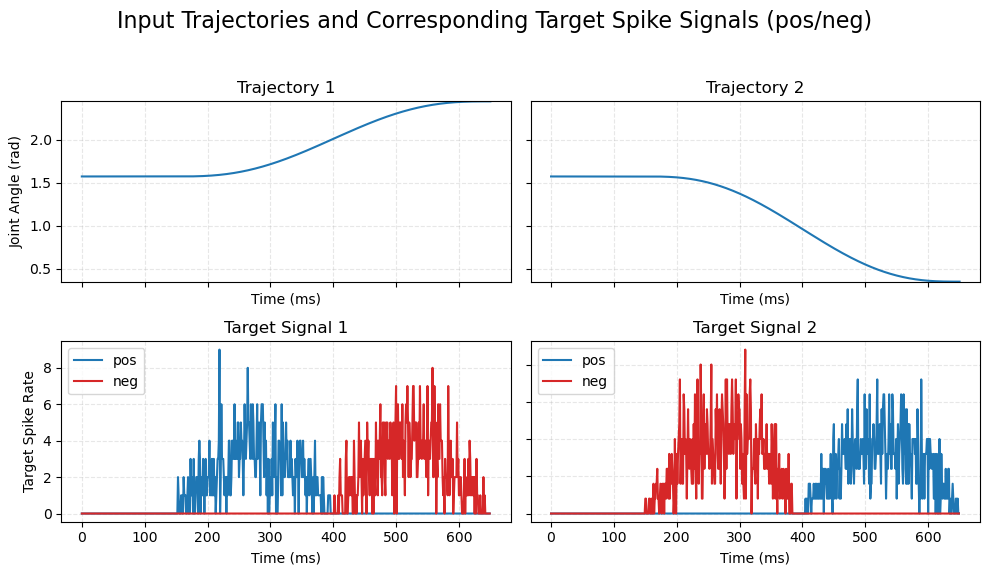

In [3]:
n_trials = len(trajectory_files)
duration_ms = 650  # duration for both trajectory and target
num_bins = 650     # one bin per ms
window = 20        # smoothing window (ms)

fig, axs = plt.subplots(2, n_trials, figsize=(5*n_trials, 6), sharex='col', 
                       gridspec_kw={'height_ratios': [1, 1]})

all_trajectories = [np.loadtxt(traj_path) for traj_path in trajectory_files]
global_min = min(traj.min() for traj in all_trajectories)
global_max = max(traj.max() for traj in all_trajectories)

for i in range(n_trials):
    # Plot trajectory
    trajectory = all_trajectories[i]
    time_traj = np.linspace(0, duration_ms, len(trajectory))
    axs[0, i].plot(time_traj, trajectory, color='tab:blue')
    axs[0, i].set_title(f"Trajectory {i+1}")
    axs[0, i].set_ylim(global_min, global_max)
    axs[0, i].grid(True, linestyle='--', alpha=0.3)
    axs[0, i].set_xlabel("Time (ms)")
    if i == 0:
        axs[0, i].set_ylabel("Joint Angle (rad)")
    else:
        axs[0, i].set_yticklabels([])

    # Plot separated "pos" and "neg" target spike rates
    tgt_path = target_files[i]
    with open(tgt_path, "r") as f:
        first_line = f.readline()
    delimiter = "," if "," in first_line else None
    target_spikes = np.loadtxt(tgt_path, delimiter=delimiter)
    if target_spikes.ndim == 1:  # If only one spike present
        target_spikes = target_spikes.reshape((1, -1))
    # "pos": neuron_id <= 50, "neg": neuron_id > 50 (repo convention)
    pos_spikes = target_spikes[target_spikes[:,0] <= 50, 1]
    neg_spikes = target_spikes[target_spikes[:,0] > 50, 1]
    pos_hist, bin_edges = np.histogram(pos_spikes, bins=num_bins, range=(0, duration_ms))
    neg_hist, _ = np.histogram(neg_spikes, bins=num_bins, range=(0, duration_ms))
    axs[1, i].plot(bin_edges[:-1], pos_hist, color='tab:blue', label='pos')
    axs[1, i].plot(bin_edges[:-1], neg_hist, color='tab:red', label='neg')
    axs[1, i].set_title(f"Target Signal {i+1}")
    axs[1, i].set_xlabel("Time (ms)")
    if i == 0:
        axs[1, i].set_ylabel("Target Spike Rate")
    else:
        axs[1, i].set_yticklabels([])
    axs[1, i].grid(True, linestyle='--', alpha=0.3)
    axs[1, i].legend()

plt.suptitle("Input Trajectories and Corresponding Target Spike Signals (pos/neg)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3. Run Simulation

Run the SNN simulation. Output is a dictionary with spike times, readout signals, loss curve, durations, and neuron IDs for further analysis.

In [4]:
results = run_simulation(**params)
# results contains:
#   - 'spikes': {'senders', 'times'}
#   - 'output_multimeter': {'senders', 'times', 'readout_signal', 'target_signal'}
#   - 'loss': training loss curve
#   - 'duration': timing info for analysis windows
#   - 'nrns_rec': recurrent neuron IDs (NEST NodeCollection or array)

Using manual RBF implementation.
Aug 15 17:53:25 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Aug 15 17:53:25 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Aug 15 17:53:25 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Aug 15 17:53:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Starting simulation for 80001.00 ms... (sequences per iter incl. silence: 100; update interval: 800.0 ms; gradient_batch_size=1; expected weight updates ≈ 100.0)
Simulation finished.

Aug 15 17:53:25 NodeManager::prepare_nodes [Info]: 
    Preparing 410 nodes for simulation.

Aug 15 17:53:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 410
    Simulation time (ms): 80001
    Number of OpenMP threads: 4
    Not using MPI

Aug 15 17:53:28 SimulationManager::run [Info]: 
    Simulation finished.
Saving trained weights...
Trained w

## 4. Define Analysis Windows: Pre- and Post-Training

We analyze network behavior before and after training (following conventions in [`eprop-motor-control/plot_results.py`](https://github.com/shimoura/motor-controller-model/blob/add-nestml-neurons/eprop-motor-control/plot_results.py)).

In [5]:
duration = results['duration']
n_trajectories = duration['n_trajectories']

# Pre-training: first trajectories
pre_train_window = (0, n_trajectories * duration['total_sequence_with_silence'])
# Post-training: last trajectories
post_train_window = (
    duration['task'] - n_trajectories * duration['total_sequence_with_silence'],
    duration['task']
)
xlims_list = [pre_train_window, post_train_window]

print(f"Pre-training window: {pre_train_window}")
print(f"Post-training window: {post_train_window}")

Pre-training window: (0, 1600.0)
Post-training window: (78400.0, 80000.0)


## 5. Spike Raster Plot: Pre- and Post-Training

Visualize firing activity of recurrent neurons (M1 population) before and after learning. Observe changes in network temporal patterns and structure.

> **Neuroscience Note:** Spike rasters reveal emergent population dynamics. Structured activity after training may reflect the network's ability to encode and generate motor commands for the task.

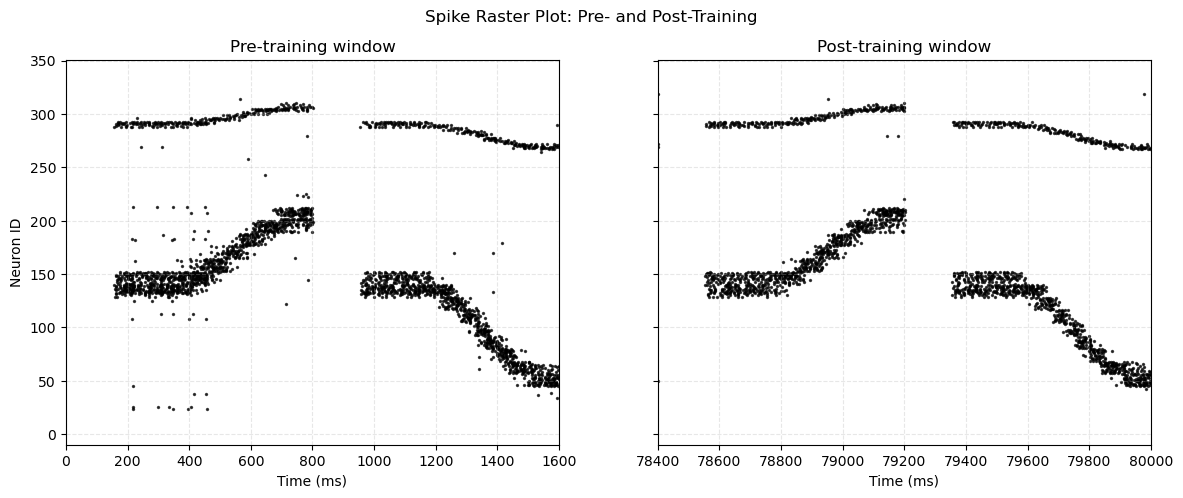

In [6]:
spikes = results['spikes']
nrns_rec = results['nrns_rec']

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, xlims in enumerate(xlims_list):
    # Filter spikes by time window
    idc_times = (spikes['times'] > xlims[0]) & (spikes['times'] < xlims[1])
    # Filter senders by recurrent neuron GIDs
    idc_sender = np.isin(spikes['senders'][idc_times], nrns_rec)
    senders_subset = spikes['senders'][idc_times][idc_sender]
    times_subset = spikes['times'][idc_times][idc_sender]
    # Get min/max GID for y-axis
    min_gid = nrns_rec[0].global_id
    max_gid = nrns_rec[-1].global_id
    margin = abs(max_gid - min_gid) * 0.1 + 1
    axs[i].scatter(times_subset, senders_subset, s=2, color='black', alpha=0.7)
    axs[i].set_ylim(min_gid - margin, max_gid + margin)
    axs[i].set_xlim(xlims)
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_title('Pre-training window' if i == 0 else 'Post-training window')
axs[0].set_ylabel('Neuron ID')
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.3)
plt.suptitle('Spike Raster Plot: Pre- and Post-Training')
plt.show()

## 6. Output vs Target Signal: Pre- and Post-Training

Compare actual network outputs to target signals for motor control ("pos"/"neg" channels). Assess learning progress and output channel accuracy.

> **Note:** Output neurons represent motor command signals. Accurate matching to targets after learning is key for effective movement control.

/tmp/ipykernel_300549/1943896140.py:60: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


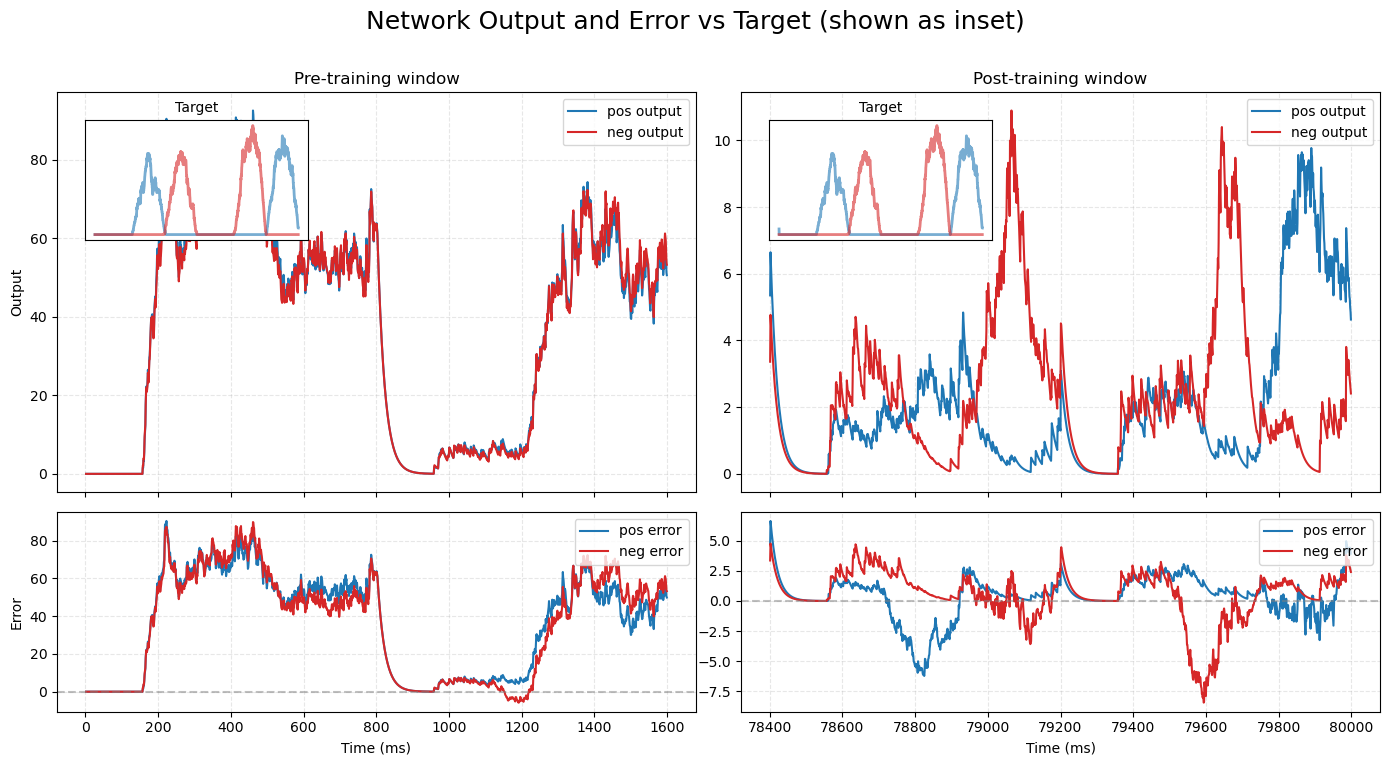

In [7]:
output_mm = results['output_multimeter']
senders = output_mm['senders']
readout = output_mm['readout_signal']
target = output_mm['target_signal']
times = output_mm['times']

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Map GIDs to channel names and colors (assume only 2 channels: pos/neg)
unique_gids = np.unique(senders)
labels = {gid: 'pos' if i == 0 else 'neg' for i, gid in enumerate(unique_gids)}
colors = {gid: 'tab:blue' if i == 0 else 'tab:red' for i, gid in enumerate(unique_gids)}

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex='col', gridspec_kw={'height_ratios': [2, 1]})

for col, xlims in enumerate(xlims_list):
    for gid in unique_gids:
        mask = (
            (senders == gid)
            & (times > xlims[0])
            & (times < xlims[1])
        )
        label = labels[gid]
        color = colors[gid]
        # Output
        axs[0, col].plot(times[mask], readout[mask], color=color, label=f'{label} output')
        # Error
        axs[1, col].plot(times[mask], readout[mask] - target[mask], color=color, label=f'{label} error')
    axs[0, col].set_title('Pre-training window' if col == 0 else 'Post-training window')
    axs[1, col].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axs[1, col].set_xlabel('Time (ms)')

    # Add target signal as inset in output plot (top left corner)
    ax_inset = inset_axes(axs[0, col], width="35%", height="30%", loc='upper left', borderpad=2)
    for gid in unique_gids:
        mask = (
            (senders == gid)
            & (times > xlims[0])
            & (times < xlims[1])
        )
        label = labels[gid]
        color = colors[gid]
        # Plot full target signal for reference, using muted color
        ax_inset.plot(times[mask], target[mask], color=color, alpha=0.6, linewidth=2, label=f'{label} target')
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_title("Target", fontsize=10)

axs[0, 0].set_ylabel('Output')
axs[1, 0].set_ylabel('Error')
for row in range(2):
    axs[row, 0].legend(loc='upper right')
    axs[row, 1].legend(loc='upper right')
for ax_row in axs:
    for ax in ax_row:
        ax.grid(True, linestyle='--', alpha=0.3)
plt.suptitle('Network Output and Error vs Target (shown as inset)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## 7. Training Loss Curve

Track the network's learning progress. A decreasing loss curve reflects successful synaptic adaptation and improved task performance.

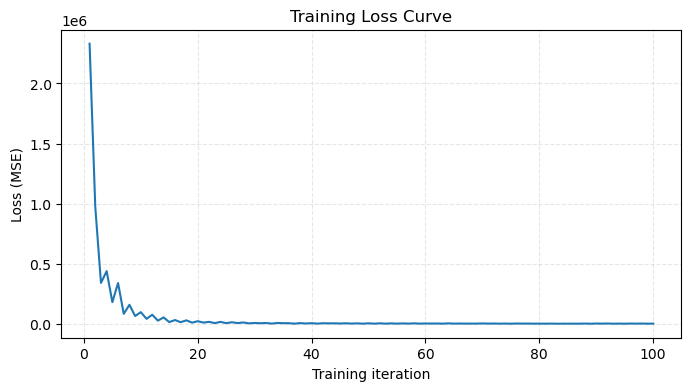

In [8]:
loss = results['loss']
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(loss)+1), loss)
plt.xlabel('Training iteration')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Curve')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## Further Reading & References

- [NEST Simulator e-prop documentation](https://nest-simulator.readthedocs.io/en/stable/auto_examples/eprop_plasticity/index.html)
- [NESTML documentation](https://nestml.readthedocs.io/en/latest/)
- Bellec G et al. (2020), Nature Communications: [A solution to the learning dilemma for recurrent networks of spiking neurons](https://doi.org/10.1038/s41467-020-17236-y)
- Pouget, A., Dayan, P., & Zemel, R. (2000). Information processing with population codes. *Nature Reviews Neuroscience*, 1(2), 125-132.
- Georgopoulos, A. P., et al. (1986). Neuronal population coding of movement direction. *Science*, 233(4771), 1416-1419.